## Install Pytorch if needed

In [0]:
# http://pytorch.org/


# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

## Import modules

In [126]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

print("Pytorch version:  " + str(torch.__version__))

Pytorch version:  1.0.0


In [127]:
BATCH_SIZE = 64
BATCH_SIZE_TEST = 1000
EPOCHS = 10
LOG_INTERVAL = 10

## Model setup

In [129]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    



In [130]:
model = Net()
model.eval()


Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

## Train setup

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Dataset setup

In [84]:


use_cuda = torch.cuda.is_available()

torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE_TEST, shuffle=True, **kwargs)




## Train process

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

torch.save(model.state_dict(),"mnist_cnn.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.213470
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.170460
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.076729
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.868197
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.414118
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.000784
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.775921
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.460183
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.486091
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.437529
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.408766
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.461533
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.429015
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.398074
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.386383
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.298286
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.502210
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.522743
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.338115
Train Epoch: 1 [12800/60000 (

In [0]:
# # Download from COLAB
# from google.colab import files
# files.download('mnist_cnn.pt') 


## Load Model

In [118]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net()
model.eval()
model.load_state_dict(torch.load("mnist_cnn.pt", map_location='cpu'))
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [119]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

PREDICTION : 9


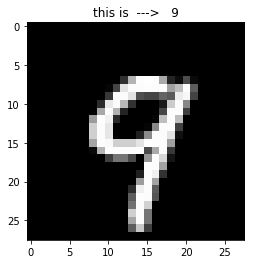

In [125]:
ind = 12

image = test_loader.dataset[ind][0].numpy().reshape(28,28)
lbl = test_loader.dataset[ind][1].numpy()
plt.title('this is  --->   ' + str(lbl))
plt.imshow(image, cmap='gray')


image_tensor, label_tensor = test_loader.dataset[ind]
image_tensor = image_tensor.reshape(1,1,28,28)
image_tensor, label_tensor = image_tensor.to(device), label_tensor.to(device)

prediction = model(image_tensor)
prediction = np.argmax(prediction.detach().numpy())
print ("\033[92m" + "PREDICTION : " + str(prediction) + "\033[0m")

-----------